## Library Import

In [5]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import warnings
import rasterio as rio

%matplotlib inline

from netCDF4 import Dataset
from pyhdf.SD import SD, SDC
from skimage.transform import resize


In [6]:
from collections import Counter

from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import  confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from skimage.transform import resize
from sklearn.metrics import mean_squared_error

ncores = os.cpu_count()

In [7]:
## Set bounds for later reading

## Read Data

In [8]:
## import LT
lt_df = pd.read_csv('data/lt.csv')
lt_col = lt_df.columns.tolist()[3:]

train_df = pd.read_csv('data/1985.csv')
train_years = ['1985', '1990', '1995', '2000', '2005']
train_df[lt_col] = lt_df[lt_col]
train_df['year'] = '1985'

for i in train_years[1:]:
    add_data = pd.read_csv('data/' + i + '.csv')
    add_data[lt_col] = lt_df[lt_col]
    add_data['year'] = i
    train_df = pd.concat([train_df, add_data])
train_df = train_df.drop(['Unnamed: 0'], axis = 1)

In [9]:
features = train_df.columns.tolist()[3:-1]
#for training

In [10]:
def strat_label(pixel):
    if pixel <2000 :
        return 1
    else:
        return 2

def binary_label(pixel):
    if pixel <100 :
        return  0
    else:
        return 1

train_df['strat_label'] = train_df['label'].map(strat_label)
train_df['binary_label'] = train_df['label'].map(binary_label)

In [11]:
train_df['strat_label'].value_counts()

1    3294291
2     216399
Name: strat_label, dtype: int64

In [12]:
test, train = train_df[train_df['year'] == '2005'], train_df[train_df['year'] != '2005']
test_labels, train_labels = test['binary_label'], train['binary_label']
test_data, train_data = test[features], train[features]

In [ ]:
test.shape

In [ ]:
clf_unb = RandomForestClassifier(n_estimators=100 , min_samples_leaf=10, max_depth=50, n_jobs=ncores)
%time clf_unb.fit(train_data, train_labels)

In [11]:
%time predictions = clf_unb.predict(test_data)
print("acc",accuracy_score(test_labels, predictions))
print("kappa", cohen_kappa_score(test_labels, predictions))
print(classification_report(test_labels, predictions))

CPU times: user 18.7 s, sys: 47.9 ms, total: 18.7 s
Wall time: 1.01 s
acc 0.9180089953826741
kappa 0.7937098151652608
              precision    recall  f1-score   support

           0       0.92      0.97      0.94    496335
           1       0.92      0.79      0.85    205803

    accuracy                           0.92    702138
   macro avg       0.92      0.88      0.90    702138
weighted avg       0.92      0.92      0.92    702138



In [13]:
train_irr = train[train['binary_label'] !=0]
train_non = train[train['binary_label'] == 0]
train_non = train_non.sample(frac=0.4, replace=False, random_state=1)
train_1 = pd.concat([train_irr, train_non])

test_labels, train_labels = test['binary_label'], train_1['binary_label']
test_data, train_data = test[features], train_1[features]

clf_bin = ExtraTreesClassifier(n_estimators=500, n_jobs=ncores)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
%time clf_bin.fit(train_data, train_labels)

CPU times: user 1h 10min 58s, sys: 19.5 s, total: 1h 11min 17s
Wall time: 2min 17s


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=32,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [14]:
%time predictions = clf_bin.predict(test_data)
print("acc",accuracy_score(test_labels, predictions))
print("kappa", cohen_kappa_score(test_labels, predictions))
print(classification_report(test_labels, predictions))
test['predictions'] = predictions

CPU times: user 2min 5s, sys: 304 ms, total: 2min 5s
Wall time: 4.54 s
acc 0.9186584403635752
kappa 0.8058811142714415
              precision    recall  f1-score   support

           0       0.95      0.93      0.94    496335
           1       0.85      0.88      0.86    205803

    accuracy                           0.92    702138
   macro avg       0.90      0.91      0.90    702138
weighted avg       0.92      0.92      0.92    702138



/home/ubuntu/anaconda3/envs/w210-dlvm/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
df_import = pd.DataFrame()
df_import['feature'] = features
df_import['importances'] = clf_bin.feature_importances_
df_import=df_import.sort_values('importances', ascending=False)
df_import.head(n = 20)

,feature,importances
82,vap_lt_var,0.038785
74,tmax_lt_var,0.028951
66,srad_lt_var,0.024255
34,tmin_var,0.019053
58,pet_lt_var,0.018980
38,vap_var,0.018782
78,tmin_lt_var,0.017313
54,def_lt_var,0.017019
72,tmax_lt_max,0.016974
79,tmin_lt_mean,0.016642


In [16]:
predictions.sum()

213672

In [17]:
test_labels.sum()

205803

In [18]:
prob_predictions = clf_bin.predict_proba(test_data)

print(prob_predictions.shape)

test_results = pd.DataFrame()
actual_05 = pd.DataFrame()

test_results['lon'], test_results['lat'] = train_df[train_df['year'] == '2005']['lon'], train_df[train_df['year'] == '2005']['lat']
test_results['prob'], test_results['predict'] = prob_predictions[:,1], predictions


actual_05['lon'], actual_05['lat'], actual_05['label'] = train_df[train_df['year'] == '2005']['lon'], train_df[train_df['year'] == '2005']['lat'], test['binary_label']

labels_05, predict_05, prob_05 = np.zeros((2160, 4320)), np.zeros((2160, 4320)), np.zeros((2160, 4320))



(702138, 2)


In [19]:
t = test_results.values.tolist()
s = actual_05.values.tolist()

for i in t: 
    predict_05[int(i[0]),int(i[1])] = i[3]
    prob_05[int(i[0]),int(i[1])] = i[2]
for i in s:
    labels_05[int(i[0]),int(i[1])] = i[2]
    
with rio.open('2001_prob_crs.tif') as src:
    ras_data = src.read()
    ras_meta = src.profile


# make any necessary changes to raster properties, e.g.:
ras_meta['nodata'] = -99

with rio.open('output/' + '2005'+ '_binary.tif', 'w', **ras_meta) as dst:
    dst.write(predict_05, 1)

with rio.open('output/' + '2005'+ '_prob.tif', 'w', **ras_meta) as dst:
    dst.write(prob_05, 1)
   

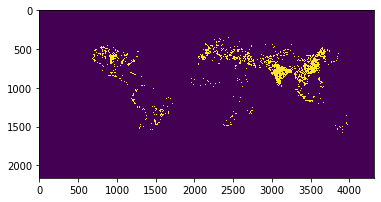

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.imshow(labels_05, interpolation='nearest')
plt.show()

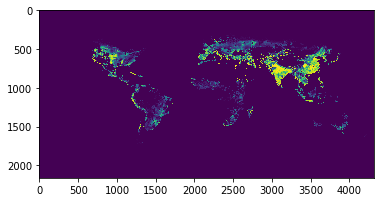

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.imshow(prob_05, interpolation='nearest')
plt.show()

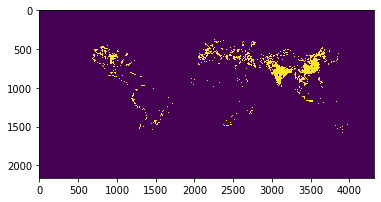

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.imshow(predict_05, interpolation='nearest')
plt.show()

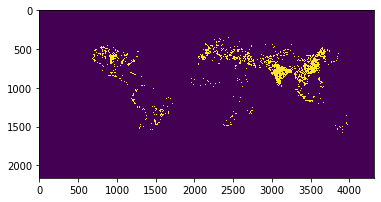

In [28]:
plt.imshow(labels_05, interpolation='nearest')

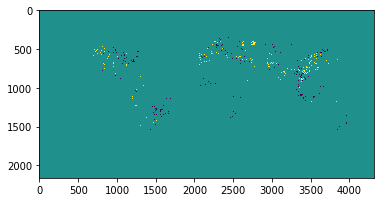

In [29]:
plt.imshow(predict_05 - labels_05, interpolation='nearest')
plt.show()

In [20]:
test_2, train_2 = test[test['predictions'] == 1], train[train['label'] > 100]
train_low = train_2[train_2['strat_label'] ==1]
train_high = train_2[train_2['strat_label'] == 2]
train_low = train_low.sample(frac=0.4, replace=False, random_state=1)
train_3 = pd.concat([train_low, train_high])



test_labels, train_labels = test_2['strat_label'], train_3['strat_label']
test_data, train_data = test_2[features], train_3[features]

In [21]:
clf_tri = ExtraTreesClassifier(n_estimators=500 , n_jobs=ncores)
%time clf_tri.fit(train_data, train_labels)

CPU times: user 14min 45s, sys: 2.79 s, total: 14min 48s
Wall time: 28.9 s


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=32,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [22]:
%time predictions = clf_tri.predict(test_data)
print("acc",accuracy_score(test_labels, predictions))
print("kappa", cohen_kappa_score(test_labels, predictions))
print(classification_report(test_labels, predictions))

CPU times: user 29.9 s, sys: 118 ms, total: 30.1 s
Wall time: 1.21 s
acc 0.9162080197686173
kappa 0.7582443491753876
              precision    recall  f1-score   support

           1       0.95      0.94      0.95    166284
           2       0.81      0.82      0.81     47388

    accuracy                           0.92    213672
   macro avg       0.88      0.88      0.88    213672
weighted avg       0.92      0.92      0.92    213672



In [23]:
test_results = pd.DataFrame()
actual_05 = pd.DataFrame()

test_results['lon'], test_results['lat'] = test_2['lon'], test_2['lat']
test_results['predict'] = predictions

predict_05 = np.zeros((2160, 4320))

In [24]:
t = test_results.values.tolist()

for i in t: 
    predict_05[int(i[0]),int(i[1])] = i[2]

    
    
with rio.open('2001_prob_crs.tif') as src:
    ras_data = src.read()
    ras_meta = src.profile


# make any necessary changes to raster properties, e.g.:
ras_meta['nodata'] = -99

with rio.open('output/' + '2005'+ '_trinary.tif', 'w', **ras_meta) as dst:
    dst.write(predict_05, 1)

In [27]:
tifs = [ '2001', '2002', '2003', '2004', '2006','2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
result_df = pd.DataFrame()
result_df['lon'], result_df['lat'] = train_df[train_df['year'] == '2005']['lon'], train_df[train_df['year'] == '2005']['lat']

def generate_year_tifs(year):
    new_df = pd.read_csv('data/' + year + '.csv')
    new_df[lt_col] = lt_df[lt_col]
    new_df['year'] = year
    new_df = new_df.drop(['Unnamed: 0'], axis = 1)
    year_data = new_df[features]
    prob_predictions, predictions = clf_bin.predict_proba(year_data), clf_bin.predict(year_data)
    
    
    new_df['bin_predictions'] = predictions
    new_df_filt = new_df[new_df['bin_predictions'] == 1]
    year_data_filt = new_df_filt[features]
    
    prediction_trinary = clf_tri.predict(year_data_filt)
    
    result_df[year + 'bin'] = predictions
    result_df[year + 'prob'] = prob_predictions[:,1]

    
    image_df = pd.DataFrame()

    image_df['lon'], image_df['lat'] = train_df[train_df['year'] == '2005']['lon'], train_df[train_df['year'] == '2005']['lat']
    image_df['prob'], image_df['predict'] = prob_predictions[:,1], predictions
    
    image_df_filt = image_df[image_df['predict'] == 1][['lon', 'lat']]
    image_df_filt['tri_predict'] = prediction_trinary
    predict, probs, trin_pred = np.zeros((2160, 4320), dtype="float64"), np.zeros((2160, 4320), dtype="float64"), np.zeros((2160, 4320), dtype="float64")

    t = image_df.values.tolist()
    s = image_df_filt.values.tolist()


    for i in t:
        predict[int(i[0]),int(i[1])] = int(i[3])
        probs[int(i[0]),int(i[1])] = int(i[2]*100)

    for i in s:
        trin_pred[int(i[0]),int(i[1])] = int(i[2])
        

    import rasterio as rio    

    with rio.open('2001_prob_crs.tif') as src:
        ras_data = src.read()
        ras_meta = src.profile


    # make any necessary changes to raster properties, e.g.:
    ras_meta['nodata'] = -99

    with rio.open('output/' + year + '_binary.tif', 'w', **ras_meta) as dst:
        dst.write(predict, 1)

    with rio.open('output/' + year + '_prob.tif', 'w', **ras_meta) as dst:
        dst.write(probs, 1)
    
    with rio.open('output/'+ year + '_trinary.tif', 'w', **ras_meta) as dst:
        dst.write(trin_pred, 1)
        
    return predict, probs, trin_pred

predicts_np = np.zeros((14,2160, 4320))
probs_np = np.zeros((14,2160, 4320))
pred_trin = np.zeros((14,2160, 4320))


for i in range(len(tifs)):
    year_p = tifs[i]
    predicts_np[i,:,:], probs_np[i,:,:], pred_trin[i,:,:]  = generate_year_tifs(year_p)

In [ ]:
print(predicts_np[1,:,:].sum())
print(predicts_np[3,:,:].sum())
print(predicts_np[5,:,:].sum())
print(predicts_np[9,:,:].sum())
print(predicts_np[12,:,:].sum())
print(predicts_np[13,:,:].sum())

In [28]:
print(pred_trin[1,:,:].sum())
print(pred_trin[3,:,:].sum())
print(pred_trin[5,:,:].sum())
print(pred_trin[9,:,:].sum())
print(pred_trin[12,:,:].sum())
print(pred_trin[13,:,:].sum())

258491.0
260921.0
258466.0
260630.0
260836.0
259000.0


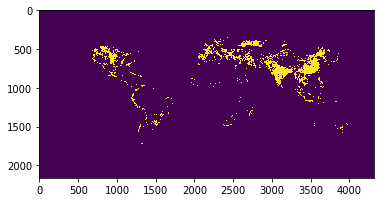

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.imshow(map_15, interpolation='nearest')
plt.show()

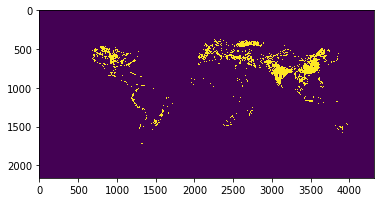

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.imshow(map_10, interpolation='nearest')
plt.show()

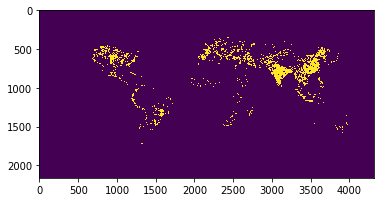

In [114]:
combined_df_05 = combined_df[combined_df['year']==2005][['lon','lat','irrigated']]
current_05 = combined_df_05.values
map_05 = np.zeros((2160, 4320))

t = current_05.tolist()

for i in t: 
    map_05[i[0],i[1]] = i[2]

plt.imshow(map_05, interpolation='nearest')
plt.show()

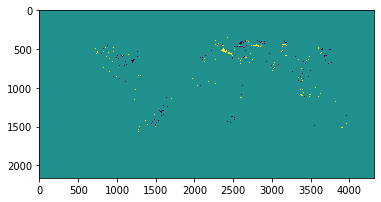

In [117]:
dif = map_15 - map_05p
plt.imshow(dif, interpolation='nearest')
plt.show()

In [10]:
train_low = train[train['strat_label'] ==1]
train_none = train[train['strat_label'] ==0]
train_high = train[train['strat_label'] == 3]
train_none = train_none.sample(frac=0.25, replace=False, random_state=1)
train_low = train_low.sample(frac=0.4, replace=False, random_state=1)
train_1 = pd.concat([train_none, train_low, train_high])

test_labels, train_labels = test['strat_label'], train_1['strat_label']
test_data, train_data = test[features], train_1[features]

clf_bal = ExtraTreesClassifier(n_estimators=500, n_jobs=ncores, min_samples_leaf=3)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
%time clf_bal.fit(train_data, train_labels)

CPU times: user 45min 48s, sys: 11.3 s, total: 45min 59s
Wall time: 1min 31s


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=32,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [11]:
%time predictions = clf_bal.predict(test_data)
print("acc",accuracy_score(test_labels, predictions))
print("kappa", cohen_kappa_score(test_labels, predictions))
print(classification_report(test_labels, predictions))

CPU times: user 2min 5s, sys: 960 ms, total: 2min 6s
Wall time: 4.66 s
acc 0.8062190053807087
kappa 0.6339252735362905
              precision    recall  f1-score   support

           0       0.87      0.85      0.86    421325
           1       0.71      0.73      0.72    233085
           3       0.77      0.80      0.78     47728

    accuracy                           0.81    702138
   macro avg       0.78      0.79      0.79    702138
weighted avg       0.81      0.81      0.81    702138



In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, predictions)

array([[ 38027,   8740,    961],
       [  9295, 170559,  53231],
       [  2055,  62275, 356995]])

In [9]:
## import LT
tifs = [ '2001', '2002', '2003', '2004', '2005','2006','2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
def generate_trinary_tifs(year):
    new_df = pd.read_csv('data/' + year + '.csv')
    new_df[lt_col] = lt_df[lt_col]
    new_df['year'] = year
    new_df = new_df.drop(['Unnamed: 0'], axis = 1)
    year_data = new_df[features]
    predictions = clf_bal.predict(year_data)

    image_df = pd.DataFrame()

    image_df['lon'], image_df['lat'] = train_df[train_df['year'] == '2005']['lon'], train_df[train_df['year'] == '2005']['lat']
    image_df['predict'] =  predictions


    predict = np.zeros((2160, 4320), dtype="float64")

    t = image_df.values.tolist()


    for i in t: 
        predict[int(i[0]),int(i[1])] = int(i[2])


    import rasterio as rio    

    with rio.open('2001_prob_crs.tif') as src:
        ras_data = src.read()
        ras_meta = src.profile


    # make any necessary changes to raster properties, e.g.:
    ras_meta['nodata'] = -99

    with rio.open('output/' + year + '_trinary.tif', 'w', **ras_meta) as dst:
        dst.write(predict, 1)
    
    return predict

predicts_np = np.zeros((15,2160, 4320))

for i in range(len(tifs)):
    year_p = tifs[i]
    predicts_np[i,:,:] = generate_trinary_tifs(year_p)

NameError: name 'clf_bal' is not defined

In [12]:
full_set = train_df[train_df['year'] == '2005'][features]
predictions = clf_bal.predict(full_set)
test_results = pd.DataFrame()
actual_05 = pd.DataFrame()

test_results['lon'], test_results['lat'] = train_df[train_df['year'] == '2005']['lon'], train_df[train_df['year'] == '2005']['lat']
test_results['predict'] = predictions


actual_05['lon'], actual_05['lat'], actual_05['label'] = train_df[train_df['year'] == '2005']['lon'], train_df[train_df['year'] == '2005']['lat'], test['binary_label']

labels_05, predict_05, = np.zeros((2160, 4320)), np.zeros((2160, 4320))



In [13]:
t = test_results.values.tolist()
s = actual_05.values.tolist()

for i in t: 
    predict_05[int(i[0]),int(i[1])] = i[2]

for i in s:
    labels_05[int(i[0]),int(i[1])] = i[2]
    
    
with rio.open('2001_prob_crs.tif') as src:
    ras_data = src.read()
    ras_meta = src.profile


# make any necessary changes to raster properties, e.g.:
ras_meta['nodata'] = -99

with rio.open('output/' + '2005'+ '_trinary.tif', 'w', **ras_meta) as dst:
    dst.write(predict_05, 1)


In [14]:
np.sum(predict_05)

389208.0

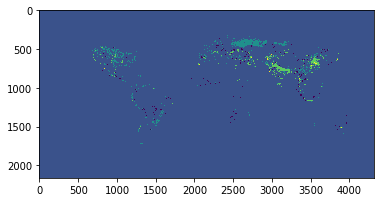

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.imshow(predict_05 - labels_05, interpolation='nearest')
plt.show()

CPU times: user 14min 44s, sys: 3.04 s, total: 14min 47s
Wall time: 29 s


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=32,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

CPU times: user 31 s, sys: 116 ms, total: 31.1 s
Wall time: 1.21 s
acc 0.9157187879014924
kappa 0.7568280924214935
              precision    recall  f1-score   support

           1       0.95      0.94      0.95    166145
           2       0.81      0.81      0.81     47402

    accuracy                           0.92    213547
   macro avg       0.88      0.88      0.88    213547
weighted avg       0.92      0.92      0.92    213547



In [43]:
test_2['lat']

424       2486
559       2427
603       2422
606       2425
607       2426
          ... 
701976    1334
701977    1335
701995    1334
701996    1335
702009    1335
Name: lat, Length: 250379, dtype: int64